# GPQA-D Performance Over Time by Price Bin

This notebook analyzes GPQA-D (GPQA Diamond) performance trends over time, binned by benchmark price.

We create four visualizations:
1. **Pareto Frontier**: Only the best models in each price bin over time (better than any previous model in that bin)
2. **All Models**: All models in each price bin with trend lines
3. **Pareto Frontier (Logit Scale)**: Best models with performance on logit scale to linearize sigmoid-shaped progress curves
4. **Price of Best Performers**: How the benchmark price of the best-performing models has changed over time

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Load the data
df = pd.read_csv('data/price_reduction_models.csv')

# Convert Release Date to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Clean GPQA-D column (epoch_gpqa) - convert percentage strings to floats
df['GPQA_D'] = df['epoch_gpqa'].astype(str).str.replace('%', '').astype(float)

# Clean Benchmark Cost USD - convert string with $ and commas to float
df['Price'] = df['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Filter out rows with missing data
df_clean = df[['Model', 'Release Date', 'GPQA_D', 'Price']].dropna()
df_clean = df_clean[df_clean['Price'] > 0]

print(f"Total models with complete data: {len(df_clean)}")
print(f"Date range: {df_clean['Release Date'].min()} to {df_clean['Release Date'].max()}")
print(f"GPQA-D range: {df_clean['GPQA_D'].min():.1f}% to {df_clean['GPQA_D'].max():.1f}%")
print(f"Price range: ${df_clean['Price'].min():.2f} to ${df_clean['Price'].max():.2f}")

Total models with complete data: 138
Date range: 2024-04-01 00:00:00 to 2025-10-01 00:00:00
GPQA-D range: 13.2% to 86.2%
Price range: $0.00 to $76.30


In [37]:
# Define price bins - using log scale bins for better distribution
# Create 4 bins: very low, low, medium, high price
price_percentiles = [0, 33, 67, 100]
price_bins = np.percentile(df_clean['Price'], price_percentiles)

# Create bin labels
bin_labels = [
    f'Low Price (${price_bins[0]:.2f}-${price_bins[1]:.2f})',
    f'Mid Price (${price_bins[1]:.2f}-${price_bins[2]:.2f})',
    f'High Price (${price_bins[2]:.2f}-${price_bins[3]:.2f})'
]

# Assign bins
df_clean['Price_Bin'] = pd.cut(df_clean['Price'], bins=price_bins, labels=bin_labels, include_lowest=True)

# Display bin statistics
print("\nModels per price bin:")
print(df_clean['Price_Bin'].value_counts().sort_index())

print("\nAverage GPQA-D per price bin:")
print(df_clean.groupby('Price_Bin')['GPQA_D'].mean().sort_index())


Models per price bin:
Price_Bin
Low Price ($0.00-$0.07)      46
Mid Price ($0.07-$1.52)      46
High Price ($1.52-$76.30)    46
Name: count, dtype: int64

Average GPQA-D per price bin:
Price_Bin
Low Price ($0.00-$0.07)      37.752174
Mid Price ($0.07-$1.52)      50.636739
High Price ($1.52-$76.30)    67.863478
Name: GPQA_D, dtype: float64


## 1. Pareto Frontier: Best Models in Each Price Bin Over Time

This plot shows only models that achieved better GPQA-D performance than any previous model in the same price bin.

Figure saved to: figures/gpqa_pareto_by_price.png


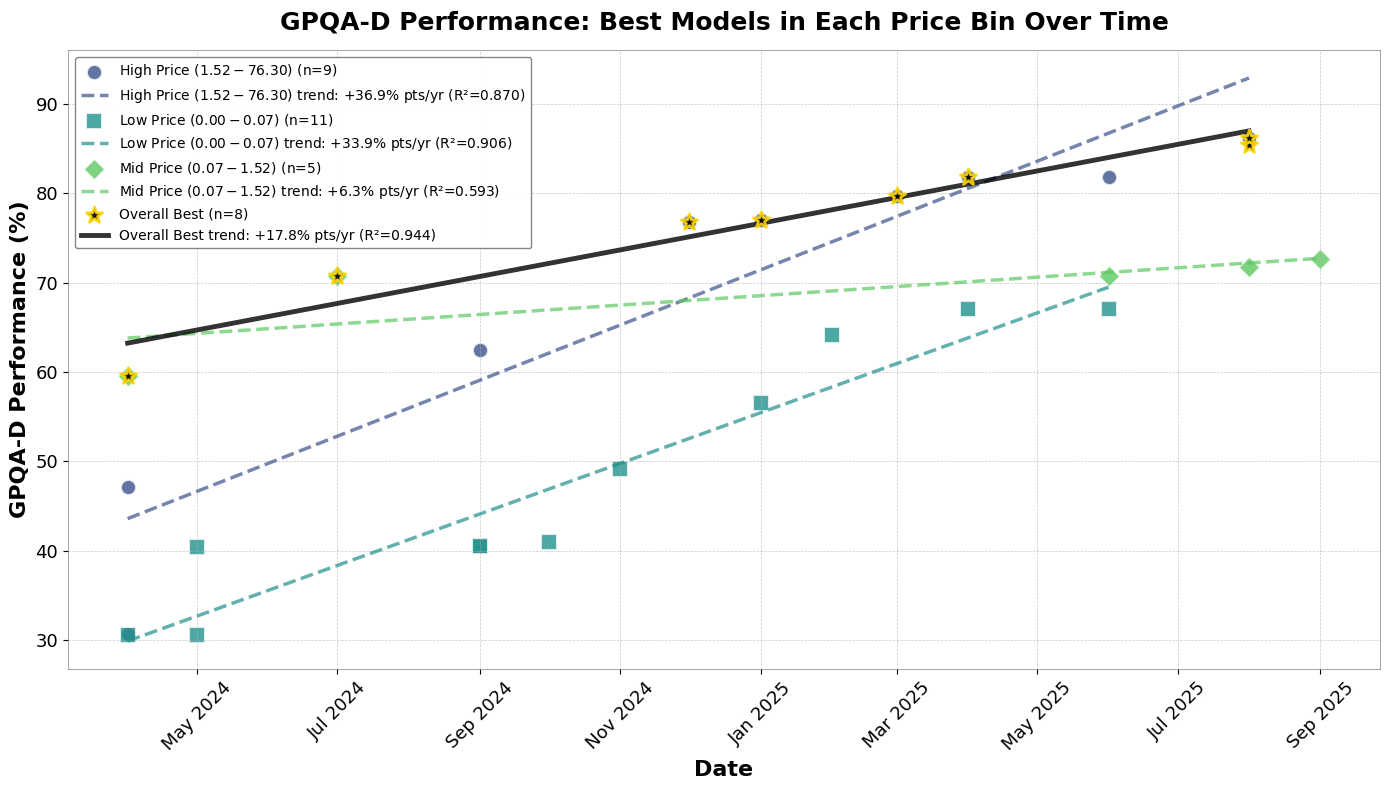

In [ ]:
def plot_pareto_frontier(df, min_date=None, save_path=None):
    """
    Plot GPQA-D performance over time for best models in each price bin.
    Only shows models that achieved better performance than any previous model in that bin.
    """
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Color palette
    palette = sns.color_palette("viridis", n_colors=3)
    markers = ['o', 's', 'D']
    
    df_work = df.copy()
    
    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]
    
    # Sort by date
    df_work = df_work.sort_values('Release Date')
    
    # Add ordinal date for regression
    df_work['Date_Ordinal'] = df_work['Release Date'].map(datetime.toordinal)
    
    # Process each price bin
    for i, bin_label in enumerate(sorted(df_work['Price_Bin'].dropna().unique())):
        color = palette[i]
        marker = markers[i]
        
        # Filter to this bin
        df_bin = df_work[df_work['Price_Bin'] == bin_label].copy()
        
        if len(df_bin) == 0:
            continue
        
        # Find Pareto frontier: models that achieved better GPQA-D than all previous
        df_bin['Is_Best'] = df_bin['GPQA_D'].cummax() == df_bin['GPQA_D']
        pareto = df_bin[df_bin['Is_Best']].copy()
        
        if len(pareto) == 0:
            continue
        
        # Scatter plot of best models
        ax.scatter(
            pareto['Release Date'],
            pareto['GPQA_D'],
            color=color,
            s=120,
            marker=marker,
            alpha=0.8,
            edgecolor='white',
            linewidth=1.5,
            label=f'{bin_label} (n={len(pareto)})'
        )
        
        # Fit trend line if we have enough points
        if len(pareto) >= 2:
            X = pareto['Date_Ordinal'].values.reshape(-1, 1)
            y = pareto['GPQA_D'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = pareto['Date_Ordinal'].min()
            max_ord = pareto['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate (percentage points per year)
            annual_improvement = model.coef_[0] * 365
            
            ax.plot(
                x_dates,
                y_pred,
                color=color,
                linestyle='--',
                linewidth=2.5,
                alpha=0.7,
                label=f'{bin_label} trend: +{annual_improvement:.1f}% pts/yr (R²={r_squared:.3f})'
            )
    
    # Add overall best (regardless of price) line
    df_work_sorted = df_work.sort_values('Release Date')
    df_work_sorted['Is_Overall_Best'] = df_work_sorted['GPQA_D'].cummax() == df_work_sorted['GPQA_D']
    overall_best = df_work_sorted[df_work_sorted['Is_Overall_Best']].copy()
    
    if len(overall_best) > 0:
        # Scatter plot of overall best models
        ax.scatter(
            overall_best['Release Date'],
            overall_best['GPQA_D'],
            color='black',
            s=150,
            marker='*',
            alpha=0.9,
            edgecolor='gold',
            linewidth=2,
            label=f'Overall Best (n={len(overall_best)})',
            zorder=10
        )
        
        # Fit trend line if we have enough points
        if len(overall_best) >= 2:
            X = overall_best['Date_Ordinal'].values.reshape(-1, 1)
            y = overall_best['GPQA_D'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = overall_best['Date_Ordinal'].min()
            max_ord = overall_best['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate (percentage points per year)
            annual_improvement = model.coef_[0] * 365
            
            ax.plot(
                x_dates,
                y_pred,
                color='black',
                linestyle='-',
                linewidth=3.5,
                alpha=0.8,
                label=f'Overall Best trend: +{annual_improvement:.1f}% pts/yr (R²={r_squared:.3f})',
                zorder=9
            )
    
    # Formatting
    ax.set_xlabel('Date', fontsize=16, fontweight='bold')
    ax.set_ylabel('GPQA-D Performance (%)', fontsize=16, fontweight='bold')
    ax.set_title('GPQA-D Performance: Best Models in Each Price Bin Over Time', 
                 fontsize=18, fontweight='bold', pad=15)
    
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='best', fontsize=10, frameon=True, fancybox=True, 
              framealpha=0.95, edgecolor='gray')
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

# Create the plot
plot_pareto_frontier(
    df_clean,
    min_date=datetime(2022, 4, 1),
    save_path='figures/gpqa_pareto_by_price.png'
)

## 2. All Models: Trends in Each Price Bin

This plot shows all models in each price bin with trend lines fitted to all data points.

Figure saved to: figures/gpqa_all_models_by_price.png


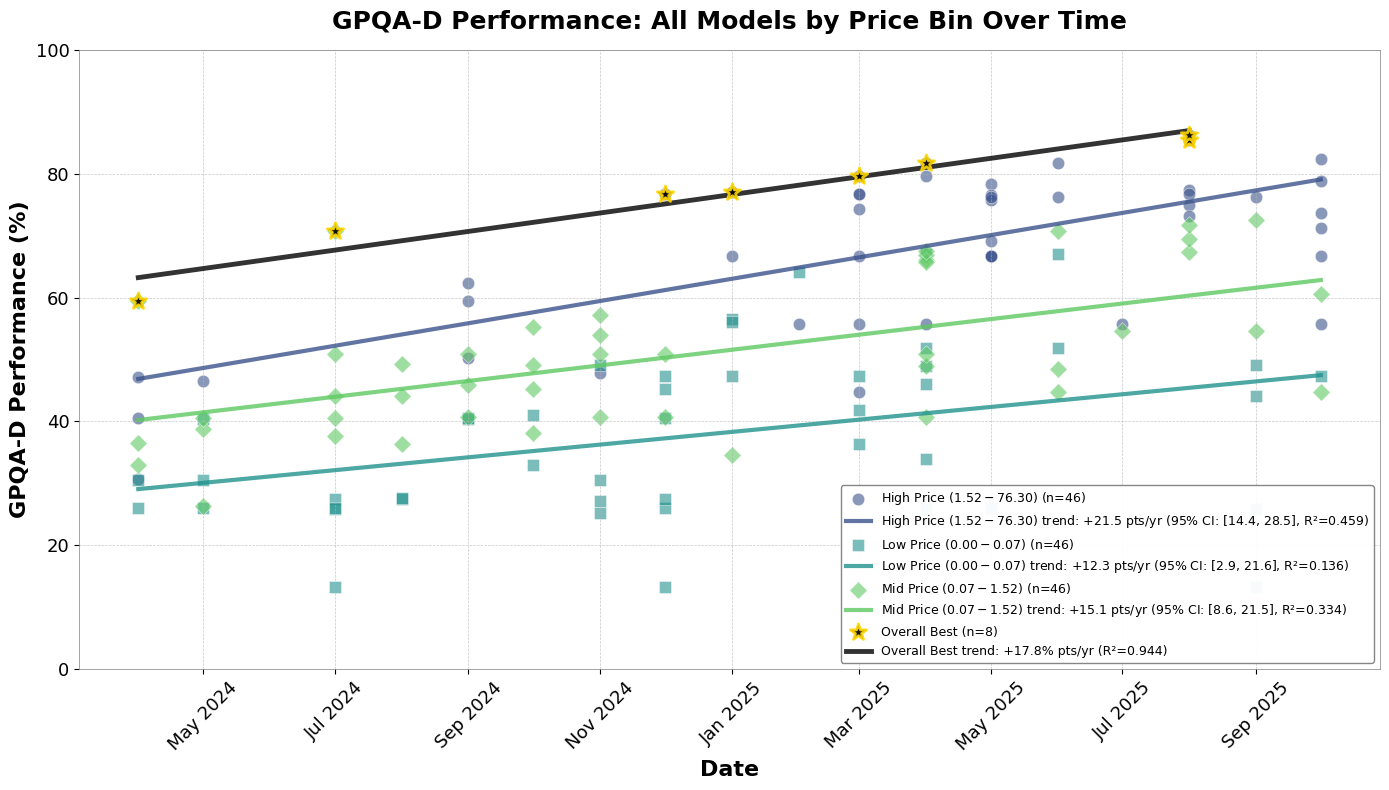

In [ ]:
def plot_all_models_trend(df, min_date=None, save_path=None):
    """
    Plot GPQA-D performance over time for all models in each price bin.
    Shows all models with trend lines for each bin.
    """
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Color palette
    palette = sns.color_palette("viridis", n_colors=3)
    markers = ['o', 's', 'D']
    
    df_work = df.copy()
    
    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]
    
    # Sort by date
    df_work = df_work.sort_values('Release Date')
    
    # Add ordinal date for regression
    df_work['Date_Ordinal'] = df_work['Release Date'].map(datetime.toordinal)
    
    # Process each price bin
    for i, bin_label in enumerate(sorted(df_work['Price_Bin'].dropna().unique())):
        color = palette[i]
        marker = markers[i]
        
        # Filter to this bin
        df_bin = df_work[df_work['Price_Bin'] == bin_label].copy()
        
        if len(df_bin) == 0:
            continue
        
        # Scatter plot of all models
        ax.scatter(
            df_bin['Release Date'],
            df_bin['GPQA_D'],
            color=color,
            s=80,
            marker=marker,
            alpha=0.6,
            edgecolor='white',
            linewidth=0.5,
            label=f'{bin_label} (n={len(df_bin)})'
        )
        
        # Fit trend line if we have enough points
        if len(df_bin) >= 2:
            X = df_bin['Date_Ordinal'].values.reshape(-1, 1)
            y = df_bin['GPQA_D'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = df_bin['Date_Ordinal'].min()
            max_ord = df_bin['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate (percentage points per year)
            annual_improvement = model.coef_[0] * 365
            
            # Calculate 95% confidence interval for slope
            n = len(X)
            y_pred_train = model.predict(X)
            residuals = y - y_pred_train
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X - np.mean(X))**2))
            t_val = stats.t.ppf(0.975, n - 2)
            ci_lower = (model.coef_[0] - t_val * se) * 365
            ci_upper = (model.coef_[0] + t_val * se) * 365
            
            ax.plot(
                x_dates,
                y_pred,
                color=color,
                linestyle='-',
                linewidth=3,
                alpha=0.8,
                label=f'{bin_label} trend: +{annual_improvement:.1f} pts/yr (95% CI: [{ci_lower:.1f}, {ci_upper:.1f}], R²={r_squared:.3f})'
            )
            
            # Add confidence band
            y_lower = (model.coef_[0] - t_val * se) * (x_range - model.intercept_/model.coef_[0])
            y_upper = (model.coef_[0] + t_val * se) * (x_range - model.intercept_/model.coef_[0])
            y_lower = model.predict(x_range.reshape(-1, 1)) + (y_lower - y_pred)
            y_upper = model.predict(x_range.reshape(-1, 1)) + (y_upper - y_pred)
            
            ax.fill_between(
                x_dates,
                y_lower,
                y_upper,
                color=color,
                alpha=0.15
            )
    
    # Add overall best (regardless of price) line
    df_work_sorted = df_work.sort_values('Release Date')
    df_work_sorted['Is_Overall_Best'] = df_work_sorted['GPQA_D'].cummax() == df_work_sorted['GPQA_D']
    overall_best = df_work_sorted[df_work_sorted['Is_Overall_Best']].copy()
    
    if len(overall_best) > 0:
        # Scatter plot of overall best models
        ax.scatter(
            overall_best['Release Date'],
            overall_best['GPQA_D'],
            color='black',
            s=150,
            marker='*',
            alpha=0.9,
            edgecolor='gold',
            linewidth=2,
            label=f'Overall Best (n={len(overall_best)})',
            zorder=10
        )
        
        # Fit trend line if we have enough points
        if len(overall_best) >= 2:
            X = overall_best['Date_Ordinal'].values.reshape(-1, 1)
            y = overall_best['GPQA_D'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = overall_best['Date_Ordinal'].min()
            max_ord = overall_best['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate (percentage points per year)
            annual_improvement = model.coef_[0] * 365
            
            ax.plot(
                x_dates,
                y_pred,
                color='black',
                linestyle='-',
                linewidth=3.5,
                alpha=0.8,
                label=f'Overall Best trend: +{annual_improvement:.1f}% pts/yr (R²={r_squared:.3f})',
                zorder=9
            )
    
    # Formatting
    ax.set_xlabel('Date', fontsize=16, fontweight='bold')
    ax.set_ylabel('GPQA-D Performance (%)', fontsize=16, fontweight='bold')
    ax.set_title('GPQA-D Performance: All Models by Price Bin Over Time', 
                 fontsize=18, fontweight='bold', pad=15)
    
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    ax.set_ylim(0, 100)  # Ensure y-axis is bounded between 0 and 100%

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='best', fontsize=9, frameon=True, fancybox=True, 
              framealpha=0.95, edgecolor='gray')
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

# Create the plot
plot_all_models_trend(
    df_clean,
    min_date=datetime(2024, 4, 1),
    save_path='figures/gpqa_all_models_by_price.png'
)

## Summary Statistics

## 4. Price of Best Performing Systems Over Time

This plot shows how the benchmark price of the best-performing models has changed over time. For each date, we identify the model with the best GPQA-D performance up to that point and plot its benchmark cost.

Figure saved to: figures/gpqa_price_of_best_performers.png


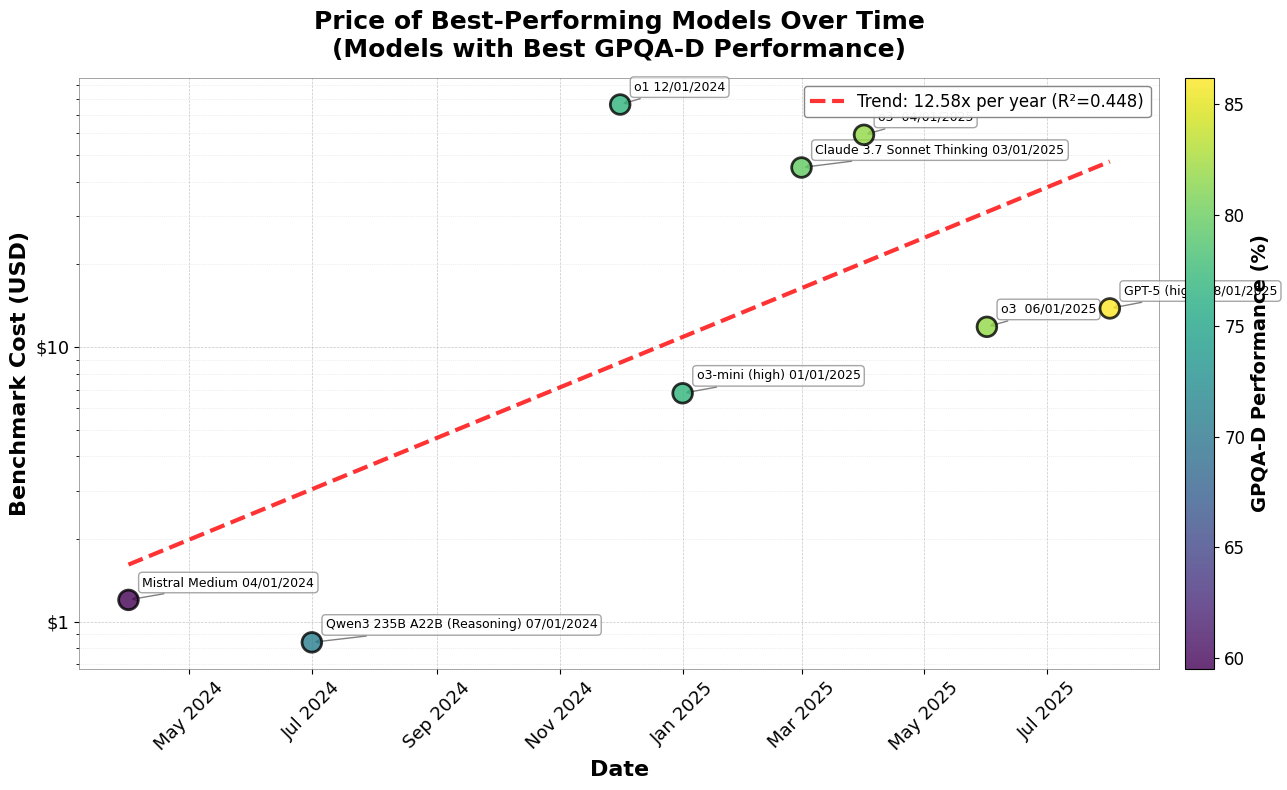


=== Price of Best Performers Summary ===
Number of record-breaking models: 8
First best model: Mistral Medium 04/01/2024 - $1.20 (GPQA-D: 59.5%)
Latest best model: GPT-5 (high) 08/01/2025 - $13.81 (GPQA-D: 86.2%)
Price range: $0.84 to $76.30
Median price: $12.83


In [40]:
def plot_price_of_best_performers(df, min_date=None, save_path=None):
    """
    Plot the benchmark price of the best-performing models over time.
    For each date, shows the price of the model with the best GPQA-D performance up to that point.
    """
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    df_work = df.copy()
    
    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]
    
    # Sort by date
    df_work = df_work.sort_values('Release Date')
    
    # Add ordinal date for regression
    df_work['Date_Ordinal'] = df_work['Release Date'].map(datetime.toordinal)
    
    # Find best performing model at each point in time
    df_work['Is_Best'] = df_work['GPQA_D'].cummax() == df_work['GPQA_D']
    best_models = df_work[df_work['Is_Best']].copy()
    
    if len(best_models) == 0:
        print("No best models found")
        return
    
    # Scatter plot of best models' prices
    scatter = ax.scatter(
        best_models['Release Date'],
        best_models['Price'],
        c=best_models['GPQA_D'],
        cmap='viridis',
        s=200,
        alpha=0.8,
        edgecolor='black',
        linewidth=2,
        zorder=5
    )
    
    # Add colorbar to show GPQA-D performance
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('GPQA-D Performance (%)', fontsize=14, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)
    
    # (Removed: gray lines connecting points)
    
    # Fit trend line if we have enough points
    if len(best_models) >= 2:
        X = best_models['Date_Ordinal'].values.reshape(-1, 1)
        y = best_models['Price'].values
        
        # Fit on log scale for price (since prices can vary by orders of magnitude)
        y_log = np.log10(y)
        model = LinearRegression().fit(X, y_log)
        r_squared = model.score(X, y_log)
        
        # Create prediction line
        min_ord = best_models['Date_Ordinal'].min()
        max_ord = best_models['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_pred_log = model.predict(x_range.reshape(-1, 1))
        y_pred = 10**y_pred_log
        
        # Calculate annual change rate (multiplicative factor)
        annual_factor = (10**model.coef_[0])**365
        
        ax.plot(
            x_dates,
            y_pred,
            color='red',
            linestyle='--',
            linewidth=3,
            alpha=0.8,
            label=f'Trend: {annual_factor:.2f}x per year (R²={r_squared:.3f})',
            zorder=4
        )
    
    # Add model names as annotations
    for idx, row in best_models.iterrows():
        ax.annotate(
            row['Model'],
            (row['Release Date'], row['Price']),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gray', lw=1)
        )
    
    # Formatting
    ax.set_xlabel('Date', fontsize=16, fontweight='bold')
    ax.set_ylabel('Benchmark Cost (USD)', fontsize=16, fontweight='bold')
    ax.set_title('Price of Best-Performing Models Over Time\n(Models with Best GPQA-D Performance)', 
                 fontsize=18, fontweight='bold', pad=15)
    
    # Use log scale for y-axis since prices can vary widely
    ax.set_yscale('log')
    
    # Custom y-axis formatter to display dollar amounts
    from matplotlib.ticker import FuncFormatter
    
    def dollar_formatter(x, pos):
        """Format y-axis values as dollar amounts"""
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    ax.legend(loc='best', fontsize=12, frameon=True, fancybox=True, 
              framealpha=0.95, edgecolor='gray')
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n=== Price of Best Performers Summary ===")
    print(f"Number of record-breaking models: {len(best_models)}")
    print(f"First best model: {best_models.iloc[0]['Model']} - ${best_models.iloc[0]['Price']:.2f} (GPQA-D: {best_models.iloc[0]['GPQA_D']:.1f}%)")
    print(f"Latest best model: {best_models.iloc[-1]['Model']} - ${best_models.iloc[-1]['Price']:.2f} (GPQA-D: {best_models.iloc[-1]['GPQA_D']:.1f}%)")
    print(f"Price range: ${best_models['Price'].min():.2f} to ${best_models['Price'].max():.2f}")
    print(f"Median price: ${best_models['Price'].median():.2f}")

# Create the plot
plot_price_of_best_performers(
    df_clean,
    min_date=datetime(2024, 4, 1),
    save_path='figures/gpqa_price_of_best_performers.png'
)

In [41]:
# Summary statistics by price bin
print("\n=== Summary Statistics by Price Bin ===")
summary = df_clean.groupby('Price_Bin').agg({
    'GPQA_D': ['mean', 'std', 'min', 'max', 'count'],
    'Price': ['mean', 'min', 'max']
}).round(2)

print(summary)

# Correlation between price and performance
correlation = df_clean['Price'].corr(df_clean['GPQA_D'])
print(f"\nCorrelation between Price and GPQA-D Performance: {correlation:.3f}")

# Recent performance (last 3 months)
recent_date = df_clean['Release Date'].max() - pd.Timedelta(days=90)
df_recent = df_clean[df_clean['Release Date'] >= recent_date]

print(f"\n=== Recent Performance (since {recent_date.strftime('%Y-%m-%d')}) ===")
print(f"Number of models: {len(df_recent)}")
print(f"Average GPQA-D: {df_recent['GPQA_D'].mean():.1f}%")
print(f"Best GPQA-D: {df_recent['GPQA_D'].max():.1f}% ({df_recent.loc[df_recent['GPQA_D'].idxmax(), 'Model']})")


=== Summary Statistics by Price Bin ===
                          GPQA_D                            Price             
                            mean    std    min   max count   mean   min    max
Price_Bin                                                                     
Low Price ($0.00-$0.07)    37.75  13.55  13.20  67.0    46   0.03  0.00   0.07
Mid Price ($0.07-$1.52)    50.64  12.02  26.32  72.6    46   0.55  0.07   1.49
High Price ($1.52-$76.30)  67.86  13.21  30.65  86.2    46  14.36  1.53  76.30

Correlation between Price and GPQA-D Performance: 0.491

=== Recent Performance (since 2025-07-03) ===
Number of models: 25
Average GPQA-D: 64.0%
Best GPQA-D: 86.2% (GPT-5 (high) 08/01/2025)


## 3. Pareto Frontier with Logit Scale

This plot shows the best models in each price bin with GPQA-D performance on a logit scale. The logit transformation is: logit(p) = log(p / (1-p)), which linearizes sigmoid-shaped progress curves and is useful for modeling bounded performance metrics.

Logit transformation summary:
GPQA-D range: 13.2% to 86.2%
Logit range: -1.88 to 1.83

Using manual price bins: [0.0, 0.05, 0.5, 2.0, 50.0, 76.30227000000001]
Models per bin:
Price_Bin
$0.00-$0.05      36
$0.05-$0.50      37
$0.50-$2.00      28
$2.00-$50.00     34
$50.00-$76.30     3
Name: count, dtype: int64
Figure saved to: figures/gpqa_pareto_by_price_logit.png


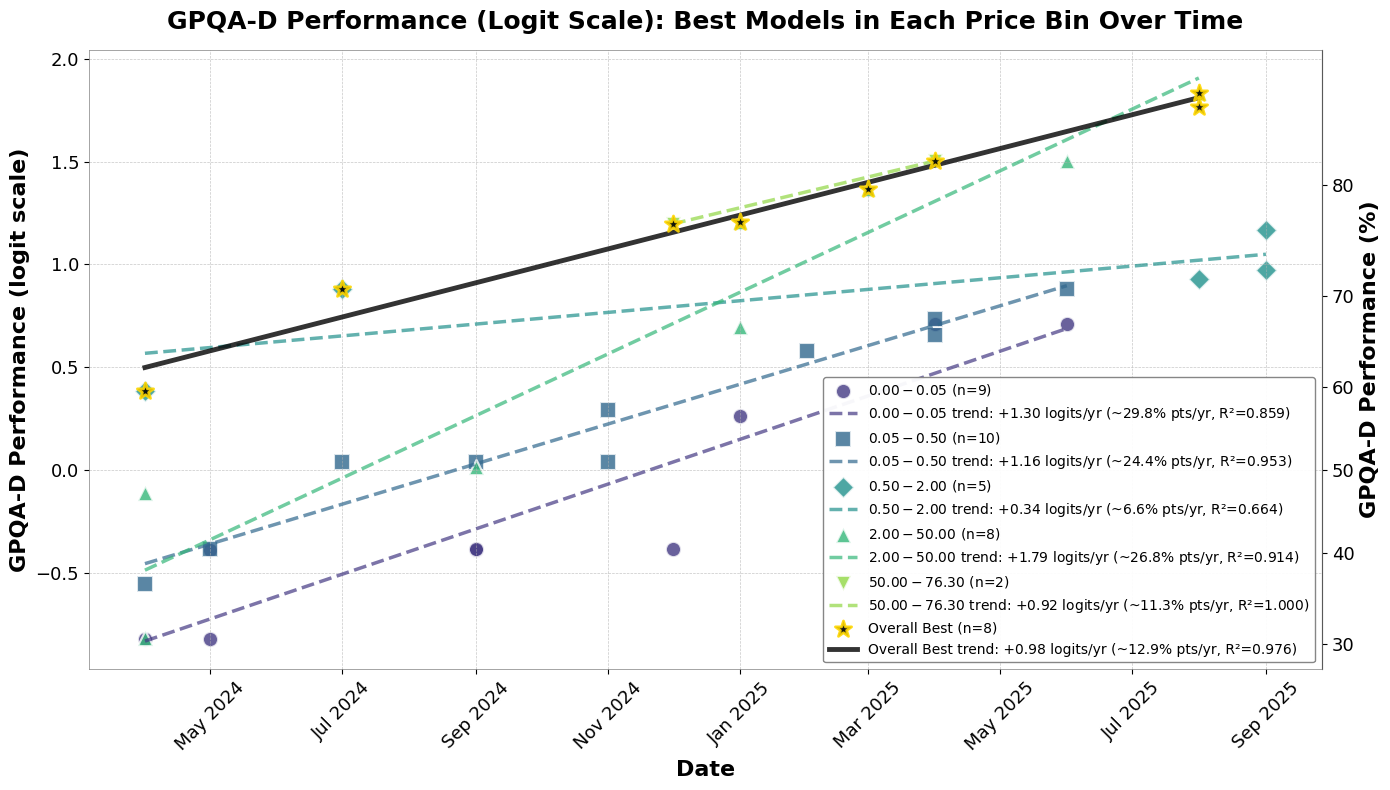

In [46]:
# Compute logit transformation for GPQA-D
# logit(p) = log(p / (1-p)) where p is probability (GPQA-D as decimal)

def logit(p):
    """Convert probability to logit scale"""
    # Clip values to avoid log(0) or log(infinity)
    p_clipped = np.clip(p, 0.001, 0.999)
    return np.log(p_clipped / (1 - p_clipped))

def inverse_logit(logit_val):
    """Convert logit back to probability"""
    return 1 / (1 + np.exp(-logit_val))

# Add logit column (convert percentage to decimal first)
df_clean['GPQA_D_logit'] = logit(df_clean['GPQA_D'] / 100)

print("Logit transformation summary:")
print(f"GPQA-D range: {df_clean['GPQA_D'].min():.1f}% to {df_clean['GPQA_D'].max():.1f}%")
print(f"Logit range: {df_clean['GPQA_D_logit'].min():.2f} to {df_clean['GPQA_D_logit'].max():.2f}")


def plot_pareto_frontier_logit(df, min_date=None, save_path=None, price_bin_edges=None):
    """
    Plot GPQA-D performance (logit scale) over time for best models in each price bin.
    Only shows models that achieved better performance than any previous model in that bin.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with columns: Model, Release Date, GPQA_D, Price, GPQA_D_logit
    min_date : datetime or str, optional
        Minimum date to filter data
    save_path : str, optional
        Path to save the figure
    price_bin_edges : list or None, optional
        Manual price bin edges. If provided, should be a list of price values defining bin boundaries.
        Example: [0.0, 0.1, 1.0, 10.0, 100.0] creates 4 bins: [0-0.1), [0.1-1.0), [1.0-10.0), [10.0-100.0]
        If None, uses existing 'Price_Bin' column from dataframe
    """
    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    df_work = df.copy()
    
    # Apply date filter if specified
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_work = df_work[df_work['Release Date'] >= min_date]
    
    # Create price bins if manual edges provided
    if price_bin_edges is not None:
        # Ensure bins include the full range
        min_price = df_work['Price'].min()
        max_price = df_work['Price'].max()
        bin_edges = sorted(price_bin_edges)
        
        # Extend bins to cover full range if needed
        if bin_edges[0] > min_price:
            bin_edges.insert(0, min_price)
        if bin_edges[-1] < max_price:
            bin_edges.append(max_price)
        
        # Create bin labels
        bin_labels = []
        for i in range(len(bin_edges) - 1):
            bin_labels.append(f'${bin_edges[i]:.2f}-${bin_edges[i+1]:.2f}')
        
        # Assign bins
        df_work['Price_Bin'] = pd.cut(df_work['Price'], bins=bin_edges, labels=bin_labels, include_lowest=True)
        
        print(f"\nUsing manual price bins: {bin_edges}")
        print(f"Models per bin:\n{df_work['Price_Bin'].value_counts().sort_index()}")
    
    # Check if Price_Bin column exists
    if 'Price_Bin' not in df_work.columns:
        raise ValueError("'Price_Bin' column not found in dataframe. Either provide price_bin_edges or ensure dataframe has 'Price_Bin' column.")
    
    # Determine number of bins for color palette
    n_bins = len(df_work['Price_Bin'].dropna().unique())
    palette = sns.color_palette("viridis", n_colors=max(n_bins, 3))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'X']
    
    # Sort by date
    df_work = df_work.sort_values('Release Date')
    
    # Add ordinal date for regression
    df_work['Date_Ordinal'] = df_work['Release Date'].map(datetime.toordinal)
    
    # Process each price bin
    for i, bin_label in enumerate(sorted(df_work['Price_Bin'].dropna().unique())):
        color = palette[i]
        marker = markers[i]
        
        # Filter to this bin
        df_bin = df_work[df_work['Price_Bin'] == bin_label].copy()
        
        if len(df_bin) == 0:
            continue
        
        # Find Pareto frontier: models that achieved better GPQA-D than all previous
        df_bin['Is_Best'] = df_bin['GPQA_D'].cummax() == df_bin['GPQA_D']
        pareto = df_bin[df_bin['Is_Best']].copy()
        
        if len(pareto) == 0:
            continue
        
        # Scatter plot of best models (using logit scale)
        ax.scatter(
            pareto['Release Date'],
            pareto['GPQA_D_logit'],
            color=color,
            s=120,
            marker=marker,
            alpha=0.8,
            edgecolor='white',
            linewidth=1.5,
            label=f'{bin_label} (n={len(pareto)})'
        )
        
        # Fit trend line if we have enough points
        if len(pareto) >= 2:
            X = pareto['Date_Ordinal'].values.reshape(-1, 1)
            y = pareto['GPQA_D_logit'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = pareto['Date_Ordinal'].min()
            max_ord = pareto['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate in logit units per year
            annual_improvement_logit = model.coef_[0] * 365
            
            # Convert to percentage point improvement at the mean performance level
            # This gives an approximate annual improvement in percentage points
            mean_gpqa = pareto['GPQA_D'].mean()
            mean_logit = logit(mean_gpqa / 100)
            future_logit = mean_logit + annual_improvement_logit
            future_prob = inverse_logit(future_logit) * 100
            annual_improvement_pct = future_prob - mean_gpqa
            
            ax.plot(
                x_dates,
                y_pred,
                color=color,
                linestyle='--',
                linewidth=2.5,
                alpha=0.7,
                label=f'{bin_label} trend: +{annual_improvement_logit:.2f} logits/yr (~{annual_improvement_pct:.1f}% pts/yr, R²={r_squared:.3f})'
            )
    
    # Add overall best (regardless of price) line
    # Stricter definition: strictly better than all previous models
    df_work_sorted = df_work.sort_values('Release Date')
    prev_best = df_work_sorted['GPQA_D'].cummax().shift(1).fillna(-np.inf)
    df_work_sorted['Is_Overall_Best'] = df_work_sorted['GPQA_D'] > prev_best
    overall_best = df_work_sorted[df_work_sorted['Is_Overall_Best']].copy()
    
    if len(overall_best) > 0:
        # Scatter plot of overall best models (using logit scale)
        ax.scatter(
            overall_best['Release Date'],
            overall_best['GPQA_D_logit'],
            color='black',
            s=150,
            marker='*',
            alpha=0.9,
            edgecolor='gold',
            linewidth=2,
            label=f'Overall Best (n={len(overall_best)})',
            zorder=10
        )
        
        # Fit trend line if we have enough points
        if len(overall_best) >= 2:
            X = overall_best['Date_Ordinal'].values.reshape(-1, 1)
            y = overall_best['GPQA_D_logit'].values
            
            model = LinearRegression().fit(X, y)
            r_squared = model.score(X, y)
            
            # Create prediction line
            min_ord = overall_best['Date_Ordinal'].min()
            max_ord = overall_best['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred = model.predict(x_range.reshape(-1, 1))
            
            # Calculate annual improvement rate in logit units per year
            annual_improvement_logit = model.coef_[0] * 365
            
            # Convert to percentage point improvement at the mean performance level
            mean_gpqa = overall_best['GPQA_D'].mean()
            mean_logit = logit(mean_gpqa / 100)
            future_logit = mean_logit + annual_improvement_logit
            future_prob = inverse_logit(future_logit) * 100
            annual_improvement_pct = future_prob - mean_gpqa
            
            ax.plot(
                x_dates,
                y_pred,
                color='black',
                linestyle='-',
                linewidth=3.5,
                alpha=0.8,
                label=f'Overall Best trend: +{annual_improvement_logit:.2f} logits/yr (~{annual_improvement_pct:.1f}% pts/yr, R²={r_squared:.3f})',
                zorder=9
            )
    
    # Formatting
    ax.set_xlabel('Date', fontsize=16, fontweight='bold')
    ax.set_ylabel('GPQA-D Performance (logit scale)', fontsize=16, fontweight='bold')
    ax.set_title('GPQA-D Performance (Logit Scale): Best Models in Each Price Bin Over Time', 
                 fontsize=18, fontweight='bold', pad=15)
    
    # Add secondary y-axis with percentage labels
    ax2 = ax.secondary_yaxis('right', functions=(lambda x: inverse_logit(x) * 100, 
                                                   lambda x: logit(x / 100)))
    ax2.set_ylabel('GPQA-D Performance (%)', fontsize=16, fontweight='bold')
    
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='best', fontsize=10, frameon=True, fancybox=True, 
              framealpha=0.95, edgecolor='gray')
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='y', which='major', labelsize=13)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

# Create the plot
# To use manual bins, pass price_bin_edges parameter:
# Example: price_bin_edges=[0.0, 0.05, 0.5, 5.0, 50.0] creates 4 bins
plot_pareto_frontier_logit(
    df_clean,
    min_date=datetime(2024, 4, 1),
    save_path='figures/gpqa_pareto_by_price_logit.png',
    price_bin_edges=[0.0, 0.05, 0.5, 2.0, 50.0]  # Uncomment to use manual bins
)






## 5. Multi-Benchmark Comparison: Price of Best Performers

This plot compares how the benchmark cost of best-performing models has changed over time across three benchmarks: GPQA-D, SWE-Bench, and AIME (OTIS Mock Time).

In [43]:
# Load data for all three benchmarks
# 1. GPQA-D (already loaded as df_clean)
# 2. SWE-Bench
# 3. AIME (OTIS Mock Time)

# Load SWE-Bench data
df_swe = pd.read_csv('data/price_reduction_models.csv')
df_swe['Release Date'] = pd.to_datetime(df_swe['Release Date'])
df_swe['SWE_Bench'] = df_swe['epoch_swe'].astype(str).str.replace('%', '').astype(float)
df_swe['Price'] = df_swe['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_swe['Price'] = pd.to_numeric(df_swe['Price'], errors='coerce')
df_swe_clean = df_swe[['Model', 'Release Date', 'SWE_Bench', 'Price']].dropna()
df_swe_clean = df_swe_clean[df_swe_clean['Price'] > 0]

# Load AIME data
df_aime = pd.read_csv('data/aime_price_reduction_models.csv')
df_aime['Release Date'] = pd.to_datetime(df_aime['Release Date'])
df_aime['AIME'] = df_aime['epoch_AIME_nosamp'].astype(str).str.replace('%', '').astype(float)
df_aime['Price'] = df_aime['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
df_aime['Price'] = pd.to_numeric(df_aime['Price'], errors='coerce')
df_aime_clean = df_aime[['Model', 'Release Date', 'AIME', 'Price']].dropna()
df_aime_clean = df_aime_clean[df_aime_clean['Price'] > 0]

print("Data loaded:")
print(f"GPQA-D: {len(df_clean)} models")
print(f"SWE-Bench: {len(df_swe_clean)} models")
print(f"AIME: {len(df_aime_clean)} models")

Data loaded:
GPQA-D: 138 models
SWE-Bench: 19 models
AIME: 61 models



GPQA-D Summary:
  Best models: 8
  Price range: $0.84 to $76.30
  Annual price factor: 12.48x

SWE-Bench Summary:
  Best models: 6
  Price range: $1.04 to $10.67
  Annual price factor: 4.03x

AIME (OTIS) Summary:
  Best models: 9
  Price range: $0.45 to $7.38
  Annual price factor: 3.90x

Figure saved to: figures/multi_benchmark_price_comparison.png


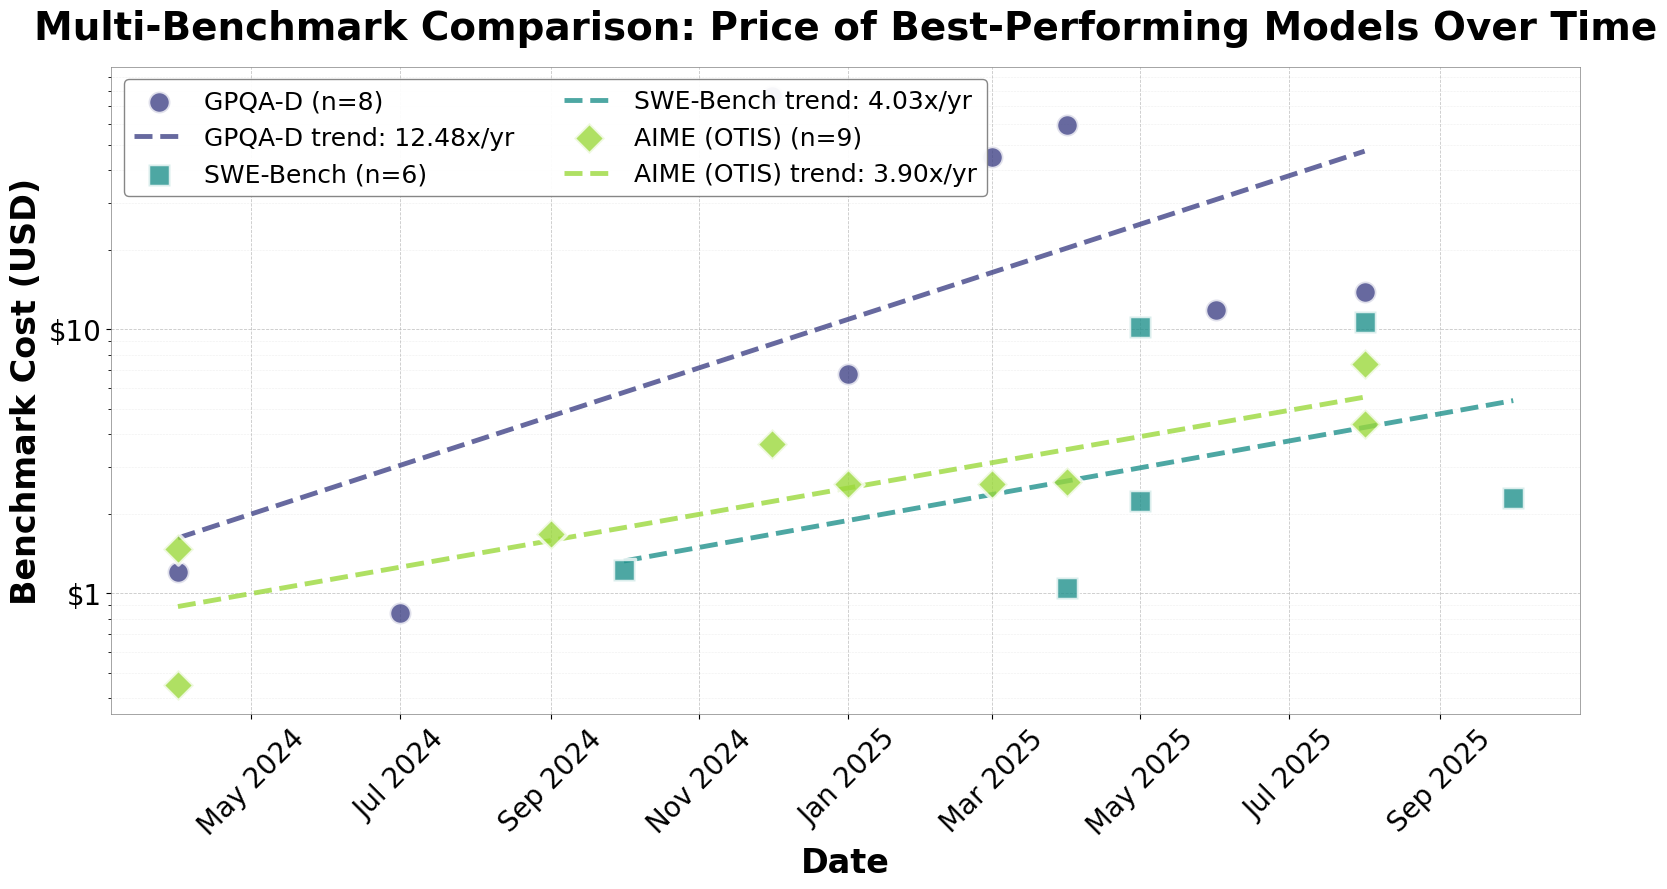

In [44]:
def plot_multi_benchmark_price_comparison(df_gpqa, df_swe, df_aime, min_date=None, save_path=None):
    """
    Plot the benchmark price of best-performing models over time across multiple benchmarks.
    For each benchmark, shows the price of models with the best performance up to that point.
    
    Parameters:
        df_gpqa: DataFrame with GPQA-D data (must have columns: Model, Release Date, GPQA_D, Price)
        df_swe: DataFrame with SWE-Bench data (must have columns: Model, Release Date, SWE_Bench, Price)
        df_aime: DataFrame with AIME data (must have columns: Model, Release Date, AIME, Price)
        min_date: Optional minimum date to filter data
        save_path: Optional path to save the figure
    """
    # ============================================================================
    # STYLE CONFIGURATION - All font sizes and point sizes in one place
    # ============================================================================
    # Font sizes
    TITLE_FONTSIZE = 28
    AXIS_LABEL_FONTSIZE = 24
    TICK_LABEL_FONTSIZE = 20
    LEGEND_FONTSIZE = 18
    
    # Point sizes
    SCATTER_POINT_SIZE = 250
    SCATTER_EDGE_WIDTH = 2.5
    TRENDLINE_WIDTH = 3.5
    
    # Grid settings
    MAJOR_GRID_WIDTH = 0.6
    MINOR_GRID_WIDTH = 0.4
    
    # Color scheme - using viridis palette
    colors = plt.get_cmap("viridis")([0.2, 0.5, 0.85])  # Three distinct colors from viridis
    # ============================================================================
    
    fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Define colors and markers for each benchmark
    benchmarks = [
        {
            'name': 'GPQA-D',
            'df': df_gpqa,
            'score_col': 'GPQA_D',
            'color': colors[0],
            'marker': 'o'
        },
        {
            'name': 'SWE-Bench',
            'df': df_swe,
            'score_col': 'SWE_Bench',
            'color': colors[1],
            'marker': 's'
        },
        {
            'name': 'AIME (OTIS)',
            'df': df_aime,
            'score_col': 'AIME',
            'color': colors[2],
            'marker': 'D'
        }
    ]
    
    # Process each benchmark
    for bench in benchmarks:
        df_work = bench['df'].copy()
        
        # Apply date filter if specified
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
        
        # Sort by date
        df_work = df_work.sort_values('Release Date')
        
        # Add ordinal date for regression
        df_work['Date_Ordinal'] = df_work['Release Date'].map(datetime.toordinal)
        
        # Find best performing model at each point in time
        df_work['Is_Best'] = df_work[bench['score_col']].cummax() == df_work[bench['score_col']]
        best_models = df_work[df_work['Is_Best']].copy()
        
        if len(best_models) == 0:
            print(f"No best models found for {bench['name']}")
            continue
        
        # Scatter plot of best models' prices
        ax.scatter(
            best_models['Release Date'],
            best_models['Price'],
            color=bench['color'],
            s=SCATTER_POINT_SIZE,
            marker=bench['marker'],
            alpha=0.8,
            edgecolor='white',
            linewidth=SCATTER_EDGE_WIDTH,
            label=f"{bench['name']} (n={len(best_models)})",
            zorder=5
        )
        
        # Fit trend line if we have enough points
        if len(best_models) >= 2:
            X = best_models['Date_Ordinal'].values.reshape(-1, 1)
            y = best_models['Price'].values
            
            # Fit on log scale for price
            y_log = np.log10(y + 0.01)  # Add small constant to avoid log(0)
            model = LinearRegression().fit(X, y_log)
            r_squared = model.score(X, y_log)
            
            # Create prediction line
            min_ord = best_models['Date_Ordinal'].min()
            max_ord = best_models['Date_Ordinal'].max()
            x_range = np.arange(min_ord, max_ord + 1)
            x_dates = [datetime.fromordinal(int(d)) for d in x_range]
            y_pred_log = model.predict(x_range.reshape(-1, 1))
            y_pred = 10**y_pred_log - 0.01
            
            # Calculate annual change rate (multiplicative factor)
            annual_factor = (10**model.coef_[0])**365
            
            ax.plot(
                x_dates,
                y_pred,
                color=bench['color'],
                linestyle='--',
                linewidth=TRENDLINE_WIDTH,
                alpha=0.8,
                label=f"{bench['name']} trend: {annual_factor:.2f}x/yr",
                zorder=4
            )
            
            print(f"\n{bench['name']} Summary:")
            print(f"  Best models: {len(best_models)}")
            print(f"  Price range: ${best_models['Price'].min():.2f} to ${best_models['Price'].max():.2f}")
            print(f"  Annual price factor: {annual_factor:.2f}x")
    
    # Formatting
    ax.set_xlabel('Date', fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold')
    ax.set_ylabel('Benchmark Cost (USD)', fontsize=AXIS_LABEL_FONTSIZE, fontweight='bold')
    ax.set_title('Multi-Benchmark Comparison: Price of Best-Performing Models Over Time', 
                 fontsize=TITLE_FONTSIZE, fontweight='bold', pad=20)
    
    # Use log scale for y-axis
    ax.set_yscale('log')
    
    # Custom y-axis formatter
    from matplotlib.ticker import FuncFormatter
    
    def dollar_formatter(x, pos):
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    ax.grid(True, which='major', linestyle='--', linewidth=MAJOR_GRID_WIDTH, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=MINOR_GRID_WIDTH, alpha=0.4)
    
    ax.legend(loc='best', fontsize=LEGEND_FONTSIZE, frameon=True, fancybox=True, 
              framealpha=0.95, edgecolor='gray', ncol=2)
    
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()

# Create the multi-benchmark comparison plot
plot_multi_benchmark_price_comparison(
    df_clean,
    df_swe_clean,
    df_aime_clean,
    min_date=datetime(2024, 4, 1),
    save_path='figures/multi_benchmark_price_comparison.png'
)